## <img src= '10DS_icon2.png' width = '80' height = '80' align = 'left'/> Data Scientist Technical Exercise
### Accident and Emergency (A&E) Performance 
The government is committed to improving **Accident and Emergency (A&E) Performance**. The headline 
performance measure for A&E is the **proportion of A&E attendances that are admitted, transferred 
or discharged from A&E within 4-hours of arrival**. As an interim target, NHSE is targeting a **national average of `0.76 (76%)`** 4-hour performance in **March 2024**. All A&E attendances are included in this 
measure.

### The Task
**Tier three support** started in **April 2023** for the following ICBs:

1. NHS Cheshire And Merseyside Integrated Care Board 
2. NHS Cornwall And The Isles Of Scilly Integrated Care Board 
3. NHS Devon Integrated Care Board 
4. NHS Greater Manchester Integrated Care Board 
5. NHS Kent And Medway Integrated Care Board 
6. NHS Norfolk And Waveney Integrated Care Board 
7. NHS North East London Integrated Care Board 

**The Secretary of State for Health has asked me to analyse NHS data to determine what impact (if 
any) the `tiering system has had on the performance of the ICBs receiving tier three support`.**

### The Dataset
The main page for A&E performance data can be found here: [Statistics » A&E Attendances and 
Emergency Admissions (england.nhs.uk)](https://www.england.nhs.uk/statistics/statistical-work-areas/ae-waiting-times-and-activity/).

For my convenience, a zip file containing the monthly data on ICB level performance as CSVs, back to April 2022 has been provided. This includes data on attendances, admissions, four
hour performance and waits from decision-to-admit. The equivalent excel files 
(which include ***additional notes on the data***) in the “Monthly Data” section of the page above can also be downloaded. 

#### Advice from No 10 Delivery Unit
**No 10 Delivery Unit** have advised that I may (wish to) consider:

* Has **being in Tier 3 impacted performance**? 
* If so, **where has it had the most impact?**  
* How does the **impact at trust-level differ from the impact at ICB-level?** 
* Has the **tiering system targeted the right ICBs?** 
* How would you approach tiering if were to repeat this exercise next year? 
* How you would develop your analysis further given more time?

### Analysis Approach
This notebook includes the following sections and/or visualizations:



In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load and Explore the datasets

In [2]:
from glob import glob

ae_files = sorted(glob('./data_ICB_Level/*.csv'))
#ae_files

In [3]:
#ae_data = pd.concat((pd.read_csv(file) for file in ae_files))
ae_data = pd.concat((pd.read_csv(file) for file in sorted(glob('./data_ICB_Level/*.csv'))))
print(ae_data.shape)
ae_data.head()

(924, 26)


,Code,System,Attendances (Type 1),Attendances (Type 2),Attendances (Type 3),Attendances (Total),Attendances in 4 hours or less (Type 1),Attendances in 4 hours or less (Type 2),Attendances under 4 hours (Type 3),Attendances under 4 hours (Total),...,Percentage in 4 hours or less (Type 2),Percentage in 4 hours or less (Type 3),Emergency Admissions via Type 1 A&E,Emergency Admissions via Type 2 A&E,Emergency Admissions via Type 3 and 4 A&E,Total Emergency Admissions via A&E,Other Emergency admissions (i.e not via A&E),Total Emergency Admissions,Number of patients spending >4 hours from decision to admit to admission,Number of patients spending >12 hours from decision to admit to admission
0,QOX,"NHS Bath And North East Somerset, Swindon And ...","16,474",249,"8,983","25,706","9,432",249,"8,855","18,536",...,100.00%,98.60%,"5,310",0,8,"5,318","3,136","8,454","2,070",158
1,QHG,"NHS Bedfordshire, Luton And Milton Keynes Inte...","21,440",0,"11,045","32,485","6,097",0,"6,719","12,816",...,-,98.90%,"6,195",0,0,"6,195","2,006","8,201",373,0
2,QHL,NHS Birmingham And Solihull Integrated Care Board,"36,567",0,"15,427","51,994","21,443",0,"15,427","36,870",...,-,100.00%,"9,699",0,0,"9,699","4,654","14,353","4,983",271
3,QUY,"NHS Bristol, North Somerset And South Gloucest...","21,228","1,949","4,289","27,466","11,888","1,894","4,279","18,061",...,97.20%,99.80%,"6,031",10,0,"6,041","2,509","8,550","2,720","1,169"
4,QU9,"NHS Buckinghamshire, Oxfordshire And Berkshire...","32,171","4,376","7,188","43,735","20,125","4,334","6,867","31,326",...,99.00%,95.50%,"9,299",822,42,"10,163","5,483","15,646","1,804",1


In [4]:
column_names = list(ae_data)
print(column_names)

['Code', 'System', 'Attendances (Type 1)', 'Attendances (Type 2)', 'Attendances (Type 3)', 'Attendances (Total) ', 'Attendances in 4 hours or less (Type 1)', 'Attendances in 4 hours or less (Type 2)', 'Attendances under 4 hours (Type 3)', 'Attendances under 4 hours (Total)', 'Attendances over 4 hours (Type 1)', 'Attendances over 4 hours (Type 2)', 'Attendances over 4 hours (Type 3)', 'Attendances over 4 hours (Total)', 'Percentage in 4 hours or less (Total)', 'Percentage in 4 hours or less (Type 1)', 'Percentage in 4 hours or less (Type 2)', 'Percentage in 4 hours or less (Type 3)', 'Emergency Admissions via Type 1 A&E', 'Emergency Admissions via Type 2 A&E', 'Emergency Admissions via Type 3 and 4 A&E', 'Total Emergency Admissions via A&E', 'Other Emergency admissions (i.e not via A&E)', 'Total Emergency Admissions', 'Number of patients spending >4 hours from decision to admit to admission', 'Number of patients spending >12 hours from decision to admit to admission']


In [5]:
ae_data.dtypes

Code                                                                         object
System                                                                       object
Attendances (Type 1)                                                         object
Attendances (Type 2)                                                         object
Attendances (Type 3)                                                         object
Attendances (Total)                                                          object
Attendances in 4 hours or less (Type 1)                                      object
Attendances in 4 hours or less (Type 2)                                      object
Attendances under 4 hours (Type 3)                                           object
Attendances under 4 hours (Total)                                            object
Attendances over 4 hours (Type 1)                                            object
Attendances over 4 hours (Type 2)                                           

### Checking for Missing values

In [6]:
z = ae_data.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Series([], dtype: int64)


In [7]:
ae_data['Other Emergency admissions (i.e not via A&E)'].head(10)

0     3,136
1     2,006
2     4,654
3     2,509
4     5,483
5     1,933
6     5,714
7     1,105
8     2,311
9    10,382
Name: Other Emergency admissions (i.e not via A&E), dtype: object

### Removing non-numerical characters from numerical columns

In [8]:
num_cols = ['Attendances (Type 1)', 'Attendances (Type 2)', 'Attendances (Type 3)', 
            'Attendances (Total) ', 'Attendances in 4 hours or less (Type 1)', 
            'Attendances in 4 hours or less (Type 2)', 'Attendances under 4 hours (Type 3)', 
            'Attendances under 4 hours (Total)', 'Attendances over 4 hours (Type 1)', 
            'Attendances over 4 hours (Type 3)', 
            'Attendances over 4 hours (Total)', 'Percentage in 4 hours or less (Total)', 
            'Percentage in 4 hours or less (Type 1)', 'Percentage in 4 hours or less (Type 2)', 
            'Percentage in 4 hours or less (Type 3)', 'Emergency Admissions via Type 1 A&E', 
            'Emergency Admissions via Type 2 A&E', 'Emergency Admissions via Type 3 and 4 A&E', 
            'Total Emergency Admissions via A&E', 'Other Emergency admissions (i.e not via A&E)', 
            'Total Emergency Admissions', 'Number of patients spending >4 hours from decision to admit to admission', 
            'Number of patients spending >12 hours from decision to admit to admission']

In [9]:
df = ae_data.copy()

for col in num_cols:
    df[col] = df[col].str.replace(' ', '', regex = True)

In [10]:
for col in num_cols:
    df[col] = df[col].str.replace('%', '', regex = True)

In [11]:
for col in num_cols:
    df[col] = df[col].str.replace(',', '', regex = True)

In [12]:
for col in num_cols:
    df[col] = df[col].str.replace('-', '', regex = True)

### Checking for missing values

In [13]:
z = df.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Emergency Admissions via Type 2 A&E          840
Emergency Admissions via Type 3 and 4 A&E    378
dtype: int64


**The columns `Emergency Admissions via Type 2 A&E`and `Emergency Admissions via Type 3 and 4 A&E` are missing too many values. It would be safe to drop both columns.**

In [14]:
drop_cols = ['Emergency Admissions via Type 2 A&E', 'Emergency Admissions via Type 3 and 4 A&E']
df.drop(drop_cols, axis = 1, inplace = True)

In [15]:
z = df.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Series([], dtype: int64)


In [16]:
df.dtypes

Code                                                                         object
System                                                                       object
Attendances (Type 1)                                                         object
Attendances (Type 2)                                                         object
Attendances (Type 3)                                                         object
Attendances (Total)                                                          object
Attendances in 4 hours or less (Type 1)                                      object
Attendances in 4 hours or less (Type 2)                                      object
Attendances under 4 hours (Type 3)                                           object
Attendances under 4 hours (Total)                                            object
Attendances over 4 hours (Type 1)                                            object
Attendances over 4 hours (Type 2)                                           

In [17]:
cols = list(df)
cols

['Code',
 'System',
 'Attendances (Type 1)',
 'Attendances (Type 2)',
 'Attendances (Type 3)',
 'Attendances (Total) ',
 'Attendances in 4 hours or less (Type 1)',
 'Attendances in 4 hours or less (Type 2)',
 'Attendances under 4 hours (Type 3)',
 'Attendances under 4 hours (Total)',
 'Attendances over 4 hours (Type 1)',
 'Attendances over 4 hours (Type 2)',
 'Attendances over 4 hours (Type 3)',
 'Attendances over 4 hours (Total)',
 'Percentage in 4 hours or less (Total)',
 'Percentage in 4 hours or less (Type 1)',
 'Percentage in 4 hours or less (Type 2)',
 'Percentage in 4 hours or less (Type 3)',
 'Emergency Admissions via Type 1 A&E',
 'Total Emergency Admissions via A&E',
 'Other Emergency admissions (i.e not via A&E)',
 'Total Emergency Admissions',
 'Number of patients spending >4 hours from decision to admit to admission',
 'Number of patients spending >12 hours from decision to admit to admission']

In [18]:
num_col2 = ['Percentage in 4 hours or less (Total)', 
            'Percentage in 4 hours or less (Type 1)', 
            'Percentage in 4 hours or less (Type 2)', 
            'Percentage in 4 hours or less (Type 3)', 
            'Emergency Admissions via Type 1 A&E', 
            'Total Emergency Admissions via A&E', 
            'Other Emergency admissions (i.e not via A&E)', 
            'Total Emergency Admissions', 
            'Number of patients spending >4 hours from decision to admit to admission', 
            'Number of patients spending >12 hours from decision to admit to admission']

In [19]:
df.dtypes

Code                                                                         object
System                                                                       object
Attendances (Type 1)                                                         object
Attendances (Type 2)                                                         object
Attendances (Type 3)                                                         object
Attendances (Total)                                                          object
Attendances in 4 hours or less (Type 1)                                      object
Attendances in 4 hours or less (Type 2)                                      object
Attendances under 4 hours (Type 3)                                           object
Attendances under 4 hours (Total)                                            object
Attendances over 4 hours (Type 1)                                            object
Attendances over 4 hours (Type 2)                                           

In [20]:
z = df.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Series([], dtype: int64)


In [21]:
df.loc[:, num_col2].head()

,Percentage in 4 hours or less (Total),Percentage in 4 hours or less (Type 1),Percentage in 4 hours or less (Type 2),Percentage in 4 hours or less (Type 3),Emergency Admissions via Type 1 A&E,Total Emergency Admissions via A&E,Other Emergency admissions (i.e not via A&E),Total Emergency Admissions,Number of patients spending >4 hours from decision to admit to admission,Number of patients spending >12 hours from decision to admit to admission
0,72.10,57.30,100.00,98.60,5310,5318,3136,8454,2070,158
1,85.90,75.00,,98.90,6195,6195,2006,8201,373,0
2,70.90,58.60,,100.00,9699,9699,4654,14353,4983,271
3,65.80,56.00,97.20,99.80,6031,6041,2509,8550,2720,1169
4,71.60,62.60,99.00,95.50,9299,10163,5483,15646,1804,1


### Helper Function to clean data

In [22]:
def clean_series(d):
    d = str(d)
    if d.isnumeric():
        return float(d)
    else:
        return 0

In [23]:
for col in num_col2:
    df[col] = df[col].apply(clean_series)

In [24]:
df.dtypes

Code                                                                          object
System                                                                        object
Attendances (Type 1)                                                          object
Attendances (Type 2)                                                          object
Attendances (Type 3)                                                          object
Attendances (Total)                                                           object
Attendances in 4 hours or less (Type 1)                                       object
Attendances in 4 hours or less (Type 2)                                       object
Attendances under 4 hours (Type 3)                                            object
Attendances under 4 hours (Total)                                             object
Attendances over 4 hours (Type 1)                                             object
Attendances over 4 hours (Type 2)                                

In [25]:
df.head()

,Code,System,Attendances (Type 1),Attendances (Type 2),Attendances (Type 3),Attendances (Total),Attendances in 4 hours or less (Type 1),Attendances in 4 hours or less (Type 2),Attendances under 4 hours (Type 3),Attendances under 4 hours (Total),...,Percentage in 4 hours or less (Total),Percentage in 4 hours or less (Type 1),Percentage in 4 hours or less (Type 2),Percentage in 4 hours or less (Type 3),Emergency Admissions via Type 1 A&E,Total Emergency Admissions via A&E,Other Emergency admissions (i.e not via A&E),Total Emergency Admissions,Number of patients spending >4 hours from decision to admit to admission,Number of patients spending >12 hours from decision to admit to admission
0,QOX,"NHS Bath And North East Somerset, Swindon And ...",16474,249,8983,25706,9432,249,8855,18536,...,0,0,0,0,5310.0,5318.0,3136.0,8454.0,2070.0,158.0
1,QHG,"NHS Bedfordshire, Luton And Milton Keynes Inte...",21440,0,11045,32485,6097,0,6719,12816,...,0,0,0,0,6195.0,6195.0,2006.0,8201.0,373.0,0.0
2,QHL,NHS Birmingham And Solihull Integrated Care Board,36567,0,15427,51994,21443,0,15427,36870,...,0,0,0,0,9699.0,9699.0,4654.0,14353.0,4983.0,271.0
3,QUY,"NHS Bristol, North Somerset And South Gloucest...",21228,1949,4289,27466,11888,1894,4279,18061,...,0,0,0,0,6031.0,6041.0,2509.0,8550.0,2720.0,1169.0
4,QU9,"NHS Buckinghamshire, Oxfordshire And Berkshire...",32171,4376,7188,43735,20125,4334,6867,31326,...,0,0,0,0,9299.0,10163.0,5483.0,15646.0,1804.0,1.0


In [26]:
z = df.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Series([], dtype: int64)


#### The headline performance measure for A&E 
* This is the **proportion** of A&E attendances that are admitted, transferred or discharged from A&E **`within 4-hours`** of arrival. 

* As an interim target, NHSE is targeting a national average of **76% 4-hour performance** in March 2024. 


**The Secretary of State for Health has asked me to analyse NHS data to determine what impact (if 
any) the `tiering system has had on the performance of the ICBs receiving tier three support`.**

### Percentages in 4 hours or less (Total)

In [27]:
cols_pct =  ['Percentage in 4 hours or less (Total)',
             'Percentage in 4 hours or less (Type 1)',
             'Percentage in 4 hours or less (Type 2)',
             'Percentage in 4 hours or less (Type 3)']  

for col in cols_pct:
    df[col] = ae_data[col].str.strip().replace('\D', '', regex = True).replace(' ', '').apply(clean_series)

In [28]:
for col in cols_pct:
    df[col] = df[col] / 100

In [29]:
df.head()

,Code,System,Attendances (Type 1),Attendances (Type 2),Attendances (Type 3),Attendances (Total),Attendances in 4 hours or less (Type 1),Attendances in 4 hours or less (Type 2),Attendances under 4 hours (Type 3),Attendances under 4 hours (Total),...,Percentage in 4 hours or less (Total),Percentage in 4 hours or less (Type 1),Percentage in 4 hours or less (Type 2),Percentage in 4 hours or less (Type 3),Emergency Admissions via Type 1 A&E,Total Emergency Admissions via A&E,Other Emergency admissions (i.e not via A&E),Total Emergency Admissions,Number of patients spending >4 hours from decision to admit to admission,Number of patients spending >12 hours from decision to admit to admission
0,QOX,"NHS Bath And North East Somerset, Swindon And ...",16474,249,8983,25706,9432,249,8855,18536,...,72.1,57.3,100.0,98.6,5310.0,5318.0,3136.0,8454.0,2070.0,158.0
1,QHG,"NHS Bedfordshire, Luton And Milton Keynes Inte...",21440,0,11045,32485,6097,0,6719,12816,...,85.9,75.0,0.0,98.9,6195.0,6195.0,2006.0,8201.0,373.0,0.0
2,QHL,NHS Birmingham And Solihull Integrated Care Board,36567,0,15427,51994,21443,0,15427,36870,...,70.9,58.6,0.0,100.0,9699.0,9699.0,4654.0,14353.0,4983.0,271.0
3,QUY,"NHS Bristol, North Somerset And South Gloucest...",21228,1949,4289,27466,11888,1894,4279,18061,...,65.8,56.0,97.2,99.8,6031.0,6041.0,2509.0,8550.0,2720.0,1169.0
4,QU9,"NHS Buckinghamshire, Oxfordshire And Berkshire...",32171,4376,7188,43735,20125,4334,6867,31326,...,71.6,62.6,99.0,95.5,9299.0,10163.0,5483.0,15646.0,1804.0,1.0


#### Save the cleaned dataset

In [30]:
df.to_csv('./data_AandE_attendances_clean/AandE_attendances_jan2024.csv', index = False)

In [31]:
df = pd.read_csv('./data_AandE_attendances_clean/AandE_attendances_jan2024.csv')
print(df.shape)
df.head(3)

(924, 24)


,Code,System,Attendances (Type 1),Attendances (Type 2),Attendances (Type 3),Attendances (Total),Attendances in 4 hours or less (Type 1),Attendances in 4 hours or less (Type 2),Attendances under 4 hours (Type 3),Attendances under 4 hours (Total),...,Percentage in 4 hours or less (Total),Percentage in 4 hours or less (Type 1),Percentage in 4 hours or less (Type 2),Percentage in 4 hours or less (Type 3),Emergency Admissions via Type 1 A&E,Total Emergency Admissions via A&E,Other Emergency admissions (i.e not via A&E),Total Emergency Admissions,Number of patients spending >4 hours from decision to admit to admission,Number of patients spending >12 hours from decision to admit to admission
0,QOX,"NHS Bath And North East Somerset, Swindon And ...",16474,249,8983,25706,9432,249,8855,18536,...,72.1,57.3,100.0,98.6,5310.0,5318.0,3136.0,8454.0,2070.0,158.0
1,QHG,"NHS Bedfordshire, Luton And Milton Keynes Inte...",21440,0,11045,32485,6097,0,6719,12816,...,85.9,75.0,0.0,98.9,6195.0,6195.0,2006.0,8201.0,373.0,0.0
2,QHL,NHS Birmingham And Solihull Integrated Care Board,36567,0,15427,51994,21443,0,15427,36870,...,70.9,58.6,0.0,100.0,9699.0,9699.0,4654.0,14353.0,4983.0,271.0


In [32]:
z = df.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Series([], dtype: int64)


In [33]:
df.dtypes

Code                                                                          object
System                                                                        object
Attendances (Type 1)                                                           int64
Attendances (Type 2)                                                           int64
Attendances (Type 3)                                                           int64
Attendances (Total)                                                            int64
Attendances in 4 hours or less (Type 1)                                        int64
Attendances in 4 hours or less (Type 2)                                        int64
Attendances under 4 hours (Type 3)                                             int64
Attendances under 4 hours (Total)                                              int64
Attendances over 4 hours (Type 1)                                              int64
Attendances over 4 hours (Type 2)                                

### Testing a One Population Proportion

### Research Question  
Did NHSE achieve the national target **proportion of `0.76 (76%)`** 4-hour performance in March 2024   of **A&E attendances that are admitted, transferred or discharged from A&E within 4-hours of arrival**?


#### State the null (H0) and alternative (H1) hypothesis
* Null Hypothesis: NHSE will archieve an A&E performance of at least **`76%`** in March 2024 (H0: p = 0.76).
* Alternative Hypothesis: NHSE will archieve an A&E performance of less than **`76%`** in March 2024 (H0: p $\lt$ 0.76).

#### Set significant level
For a **95%** confidence level the significance level is alpha is **5%** ($\alpha = 0.05$).

### Testing a One Population Proportion

$TestStatistic = \frac{BestEstimate - HypothesizedEstimate}{StandardErrorOfEstimate} = \frac{\bar{p} - p_0}{SE}$

$SE(\bar{p}) = \sqrt{\frac{p.(1 - p)}{n}} => SE(\bar{p}) = \sqrt{\frac{p_0.(1 - p_0)}{n}}$  since we don't know the population **p** yet we can approximate it using $p_0$.

#### Assumptions
* **A&E attendances** were sampled randomly 
* The sample size is large enough for us to assume that the distribution of our sample is **normal** (`n x p0 > 10`) and `n x (1 - p0) > 10`).

In [34]:
data = df.loc[:, 'Percentage in 4 hours or less (Total)']
print(data.describe())

count    924.000000
mean      71.340801
std        6.589403
min       48.800000
25%       67.400000
50%       71.300000
75%       75.200000
max      100.000000
Name: Percentage in 4 hours or less (Total), dtype: float64


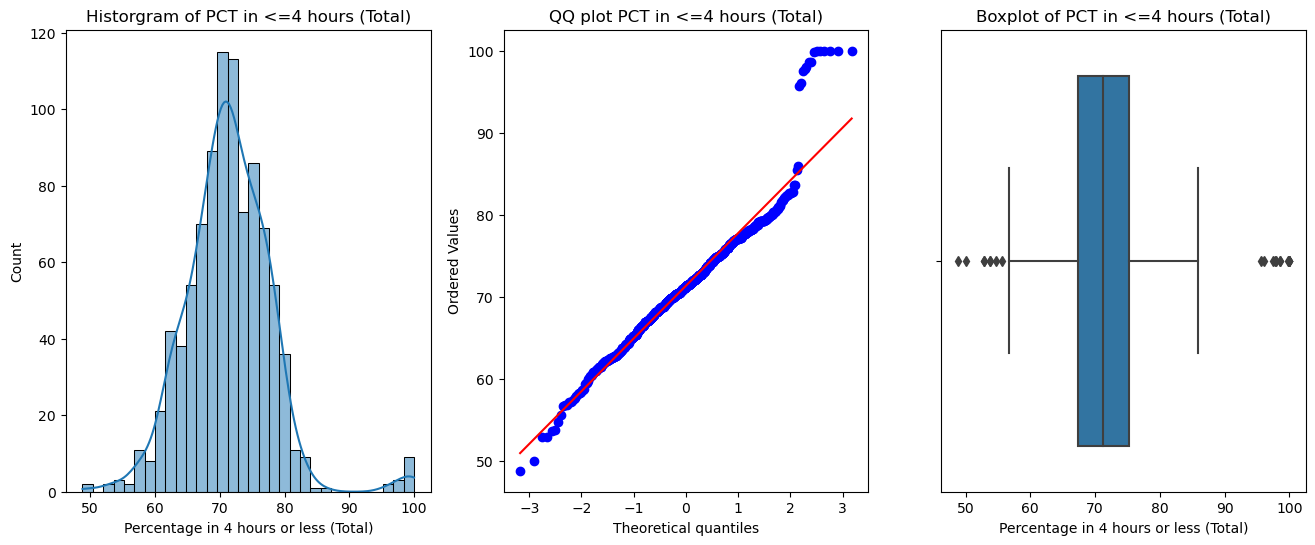

In [35]:
fig, axes = plt.subplots(1, 3, figsize = (16, 6), sharex = False)
sns.histplot(data, kde = True, ax = axes[0])
axes[0].title.set_text('Historgram of PCT in <=4 hours (Total)')
stats.probplot(data, dist = 'norm', plot = axes[1])              
axes[1].title.set_text('QQ plot PCT in <=4 hours (Total)')
sns.boxplot(x = data, ax = axes[2])
axes[2].title.set_text('Boxplot of PCT in <=4 hours (Total)')
plt.show()

In [36]:
fig.savefig('./Technical round materials/charts/hist_qq_box_pct_total.png')

In [37]:
n = data.describe()['count']                           # Number of samples
p0 = 0.76                                              # the null hypothesis
x = np.sum(data > 76)                                  # Number of samples greater than target
p_hat = x / n                                          # sample proportion
print(f'Best Estimate (p_hat) = {round(p_hat, 3)}')

Best Estimate (p_hat) = 0.208


#### Check assumptions
For a **binomial distribution** if $np \gt 10$ and $n(1 - p) \gt 10$ then the distribution can be approximated as **normal** and the **Central Limit Theorem** can be applied to any sample drawn from the population.

In [38]:
if (n * p0 > 10) & (n * (1 - p0) > 10):
    print('Assumption is met :)!')
else:
    print('Assumption is not met :(!')

Assumption is met :)!


**We will use statsmodels's `stats.proportions_ztest` method to compute the test statistic and p-value**.

In [39]:
H0 = "NHSE will achieve an A&E performance of at least 76% in March 2024 (H0: p = 0.76)"
H1 = "NHSE will achieve an A&E performance of less than 76% in March 2024"

alpha = 0.05 
test_stat, pvalue = sm.stats.proportions_ztest(x, n, p0, alternative = 'smaller')
print(f'test Statistic (z-value) = {test_stat: .3f}\np-value = {pvalue: .4f}\n')

if pvalue <= alpha:
    print(f'Significant outcome! Reject the null hypothesis which states that:\n{H0}\n')
else:
    print(f'Not significant outcome! Fail to reject the null hypothesis which states that:\n{H0}')
    print('The results from the observed sample is due to random chance!')

test Statistic (z-value) = -41.372
p-value =  0.0000

Significant outcome! Reject the null hypothesis which states that:
NHSE will achieve an A&E performance of at least 76% in March 2024 (H0: p = 0.76)



#### What does this mean?
**Rejecting the null hypothesis** means that the observed result (from sample data) of **0.208 or 20.8%** is **not** due to random chance but due to an underlying population characteristics! 

* The **test statistic = -41.372** is negative suggesting that the **proportion** of **A&E attendances that are admitted, transferred or discharged from A&E within 4-hours of arrival** is **less than 76%**!

### Computing Confidence Interval using statsmodels's `stats` package
**Confidence Interval for a proportion** is easily handled by statsmodels's **`stats.proportion_confint`** which accepts **2** arguments: **`x = number of respondents who answered YES`** and **`n = Total number of respondents`**.

In [40]:
ci = sm.stats.proportion_confint(x, n)
print(f'Confidence Interval = ({ci[0]: .4f}, {ci[1]: .4f}) or ({ci[0]*100: .2f}%, {ci[1]*100: .2f}%)')

Confidence Interval = ( 0.1816,  0.2340) or ( 18.16%,  23.40%)


#### Interpretation of the results
With **95%** confidence, the **proportion** of **A&E attendances that are admitted, transferred or discharged from A&E within 4-hours of arrival** is *estimated* to be between **18.16%** and  **23.40%**. The center of this interval is the **best estimate = 20.8%** of the population parameter.

* **NOTE: The Null value of `76%` is not within the confidence interval**!

This means, if this procedure were repeated over and over, each time computing the **95%** confidence interval estimate, we would expect **95% of those resulting `intervals` to contain the true population proportion of `A&E attendances that are admitted, transferred or discharged from A&E within 4-hours of arrival` and `76%` will not be within this interval!**.

### Tier Three ICBs

In [41]:
t3_icbs = ['NHS Cheshire And Merseyside Integrated Care Board',
           'NHS Cornwall And The Isles Of Scilly Integrated Care Board',
           'NHS Devon Integrated Care Board',
           'NHS Greater Manchester Integrated Care Board',
           'NHS Kent And Medway Integrated Care Board',
           'NHS Norfolk And Waveney Integrated Care Board',
           'NHS North East London Integrated Care Board'
          ]
t3_data = df.loc[df.System.isin(t3_icbs), 'Percentage in 4 hours or less (Total)']
t3_data.head()

6     72.3
7     76.9
10    68.1
12    70.8
15    63.3
Name: Percentage in 4 hours or less (Total), dtype: float64

In [42]:
print(len(t3_data))

154


In [43]:
print(t3_data.describe())

count    154.000000
mean      70.416883
std        6.229487
min       53.800000
25%       65.375000
50%       70.450000
75%       76.225000
max       82.300000
Name: Percentage in 4 hours or less (Total), dtype: float64


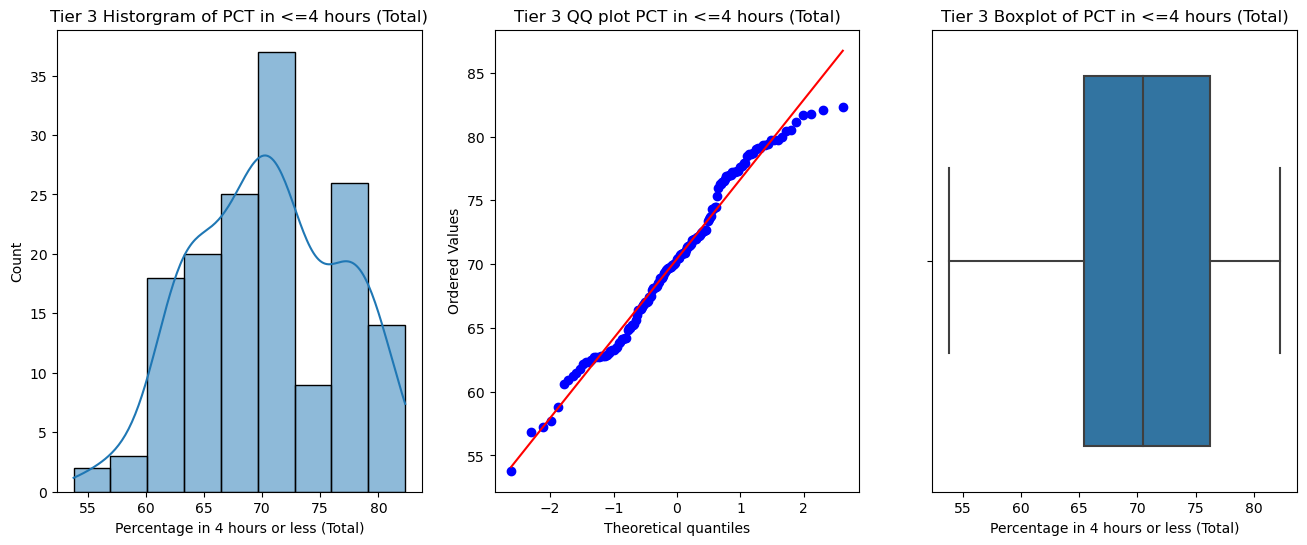

In [44]:
fig, axes = plt.subplots(1, 3, figsize = (16, 6), sharex = False)
sns.histplot(t3_data, kde = True, ax = axes[0])
axes[0].title.set_text('Tier 3 Historgram of PCT in <=4 hours (Total)')
stats.probplot(t3_data, dist = 'norm', plot = axes[1])              
axes[1].title.set_text('Tier 3 QQ plot PCT in <=4 hours (Total)')
sns.boxplot(x = t3_data, ax = axes[2])
axes[2].title.set_text('Tier 3 Boxplot of PCT in <=4 hours (Total)')
plt.show()

In [45]:
fig.savefig('./Technical round materials/charts/t3_hist_qq_box_pct_total.png')

In [46]:
n = t3_data.describe()['count']                           # Number of samples
p0 = 0.76                                                 # the null hypothesis
x = np.sum(t3_data > 76)                                  # Number of samples greater than target
p_hat = x / n                                             # sample proportion
print(f'Best Estimate (p_hat) = {round(p_hat, 3)}')

Best Estimate (p_hat) = 0.253


### Check Assumptions

In [47]:
if (n * p0 > 10) & (n * (1 - p0) > 10):
    print('Assumption is met :)!')
else:
    print('Assumption is not met :(!')

Assumption is met :)!


### Testing the hypothesis

In [48]:
H0 = "NHSE will achieve an A&E performance of at least 76% in March 2024 for Tier 3"
H1 = "NHSE will achieve an A&E performance of less than 76% in March 2024 for Tier 3"

alpha = 0.05 
test_stat, pvalue = sm.stats.proportions_ztest(x, n, p0, alternative = 'smaller')
print(f'test Statistic (z-value) = {test_stat: .3f}\np-value = {pvalue: .4f}\n')

if pvalue <= alpha:
    print(f'Significant outcome! Reject the null hypothesis which states that:\n{H0}\n')
else:
    print(f'Not significant outcome! Fail to reject the null hypothesis which states that:\n{H0}')
    print('The results from the observed sample is due to random chance!')

test Statistic (z-value) = -14.461
p-value =  0.0000

Significant outcome! Reject the null hypothesis which states that:
NHSE will achieve an A&E performance of at least 76% in March 2024 for Tier 3



### Calculate Confidence Interval

In [49]:
ci = sm.stats.proportion_confint(x, n)
print(f'Confidence Interval = ({ci[0]: .4f}, {ci[1]: .4f}) or ({ci[0]*100: .2f}%, {ci[1]*100: .2f}%)')

Confidence Interval = ( 0.1846,  0.3219) or ( 18.46%,  32.19%)


#### Interpretation of the results
With **95%** confidence, the **proportion** of **Tier 3 A&E attendances that are admitted, transferred or discharged from A&E within 4-hours of arrival** is *estimated* to be between **18.46%** and  **32.19%**. The center of this interval is the **best estimate = 25.3%** of the population parameter.

* **NOTE: The Null value of `76%` is not within the confidence interval**!

### My Response to the Secretary of State for Health
***The Secretary of State for Health has asked me to analyse NHS data to determine what impact (if 
any) the `tiering system has had on the performance of the ICBs receiving tier three support`.***

* With **95%** confidence, the **proportion** of **`Trust-Level` A&E attendances that are admitted, transferred or discharged from A&E within 4-hours of arrival** is *estimated* to be between **18.16%** and  **23.40%**. The center of this interval is the **best estimate = 20.8%** of the population parameter.

* With **95%** confidence, the **proportion** of **`Tier 3 (ICBs)` A&E attendances that are admitted, transferred or discharged from A&E within 4-hours of arrival** is *estimated* to be between **18.46%** and  **32.19%**. The center of this interval is the **best estimate = 25.3%** of the population parameter.

### Conclusions
* Has **being in Tier 3 impacted performance**?: **`No significant being in Tier 3`**

* If so, **where has it had the most impact?**: **`No significant being in Tier 3`**  

* How does the **impact at trust-level differ from the impact at ICB-level?**: **`No noticeable difference in impact between trust-level and ICB-level`**

* Has the **tiering system targeted the right ICBs?**: **`Probably not. Subject matter knowledge is highly needed to answer this question`** 

* How would you approach tiering if were to repeat this exercise next year?: **`Subject matter knowledge is highly needed to answer this question`** 

* How you would develop your analysis further given more time?: **`With more time I would have had a conversation with an subject expert so as to better understand the Policy Problem`**.